In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression

### Check and split the data

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
# read in the data
shots = pd.read_pickle('data/shots.pkl')
shots_log = pd.read_pickle('data/shots_log.pkl')

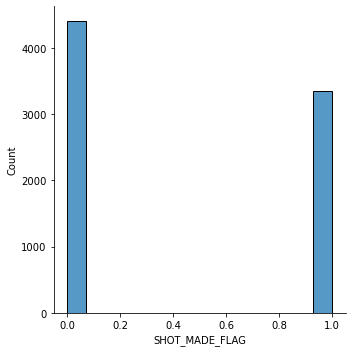

In [7]:
# check distribution of target variable
sns.displot(shots['SHOT_MADE_FLAG'])

In [9]:
# main shot data
X, y = shots.drop('SHOT_MADE_FLAG', axis=1), shots['SHOT_MADE_FLAG']

# hold out 20% of data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

# further partition into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [10]:
# logistic regression shot data (with reference categories held out)
Xlog, ylog = shots_log.drop('SHOT_MADE_FLAG', axis=1), shots_log['SHOT_MADE_FLAG']

# hold out 20% of data for final testing
Xlog, Xlog_test, ylog, ylog_test = train_test_split(Xlog, ylog, test_size=.2, random_state=10)

# further partition into train and val sets
Xlog_train, Xlog_val, ylog_train, ylog_val = train_test_split(Xlog, ylog, test_size=.25, random_state=3)

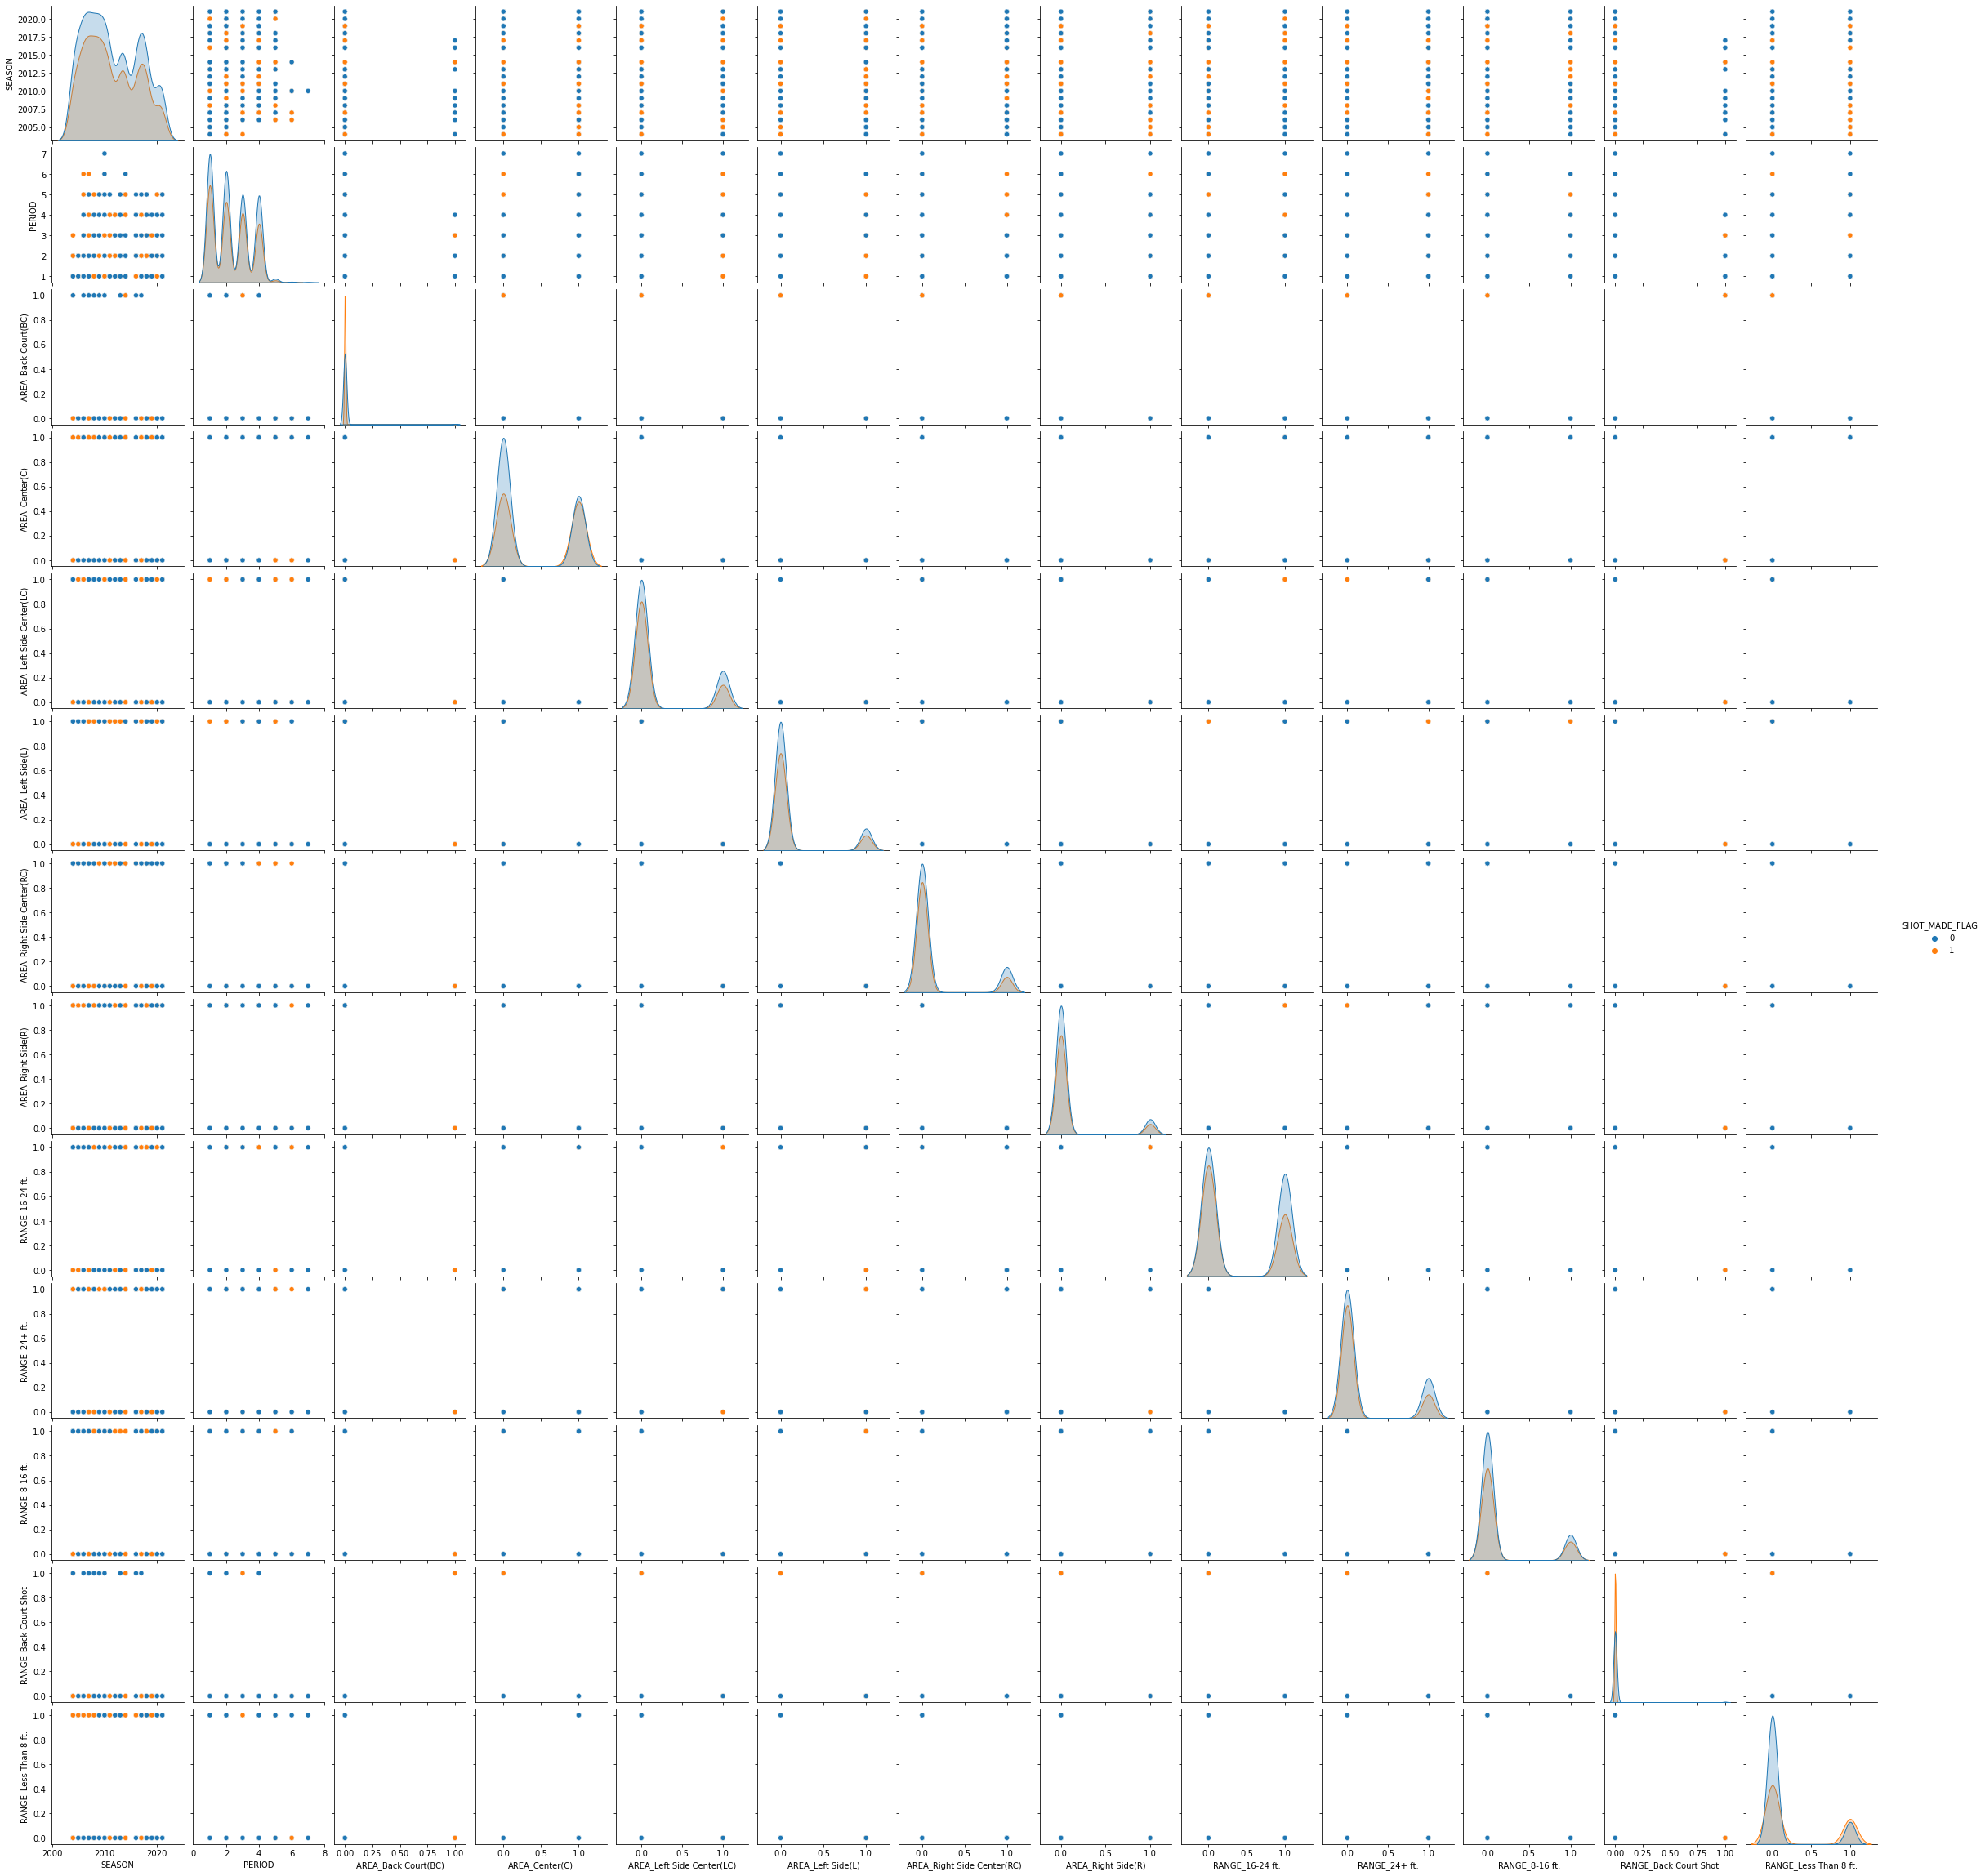

In [12]:
sns.pairplot(shots, hue='SHOT_MADE_FLAG')

As expected, these features don't separate the target class linearly. However, a logistic regression will still likely not perform well on this data, because feature intereactions are important but not immediately available for a logistic regression. I'll use it as a baseline model. 

### Logistic regression

In [19]:
# create instance of LogisticRegression
logreg = LogisticRegression(C=100)
logreg.fit(Xlog_train, ylog_train)


LogisticRegression(C=100)

In [20]:
logreg.score(Xlog_val, ylog_val)

0.6104314230521571

Not great, but as expected. Let's look at some other performance metrics.

In [21]:
ylog_pred = logreg.predict(Xlog_val)
from sklearn.metrics import precision_score, recall_score, f1_score

# using default threshold of 0.5:
print(f'Precision: {precision_score(ylog_val, ylog_pred)}')
print(f"Recall: {recall_score(ylog_val, ylog_pred)}")
print(f"F1: {f1_score(ylog_val, ylog_pred)}")

Precision: 0.5900621118012422
Recall: 0.2865761689291101
F1: 0.38578680203045684


The precision score should be priority given that we want to be able to believe a predicted positive case with higher confidence than the confidence we need in not missing any positive cases (recall). In other words, missing a positive case (a made shot) just represents a missed opportunity, but mistaking a true miss for a made shot would potentially mean setting up a play to result in a missed shot (more costly). A precision score of 0.59 isn't that bad considering a logistic regression is not the right model for our problem. 

Text(0.5, 1.0, 'Precision and Recall Curves')

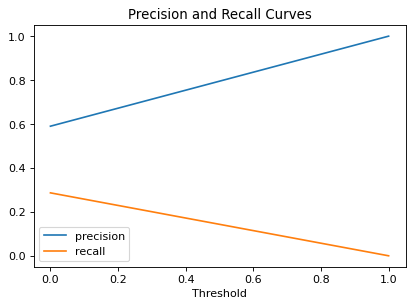

In [23]:
# Visualizing the curves
from sklearn.metrics import precision_recall_curve

p_curve, r_curve, t_curve = precision_recall_curve(ylog_val, ylog_pred)

plt.figure(dpi=80)
plt.plot(t_curve, p_curve[1:], label='precision')
plt.plot(t_curve, r_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold')
plt.title('Precision and Recall Curves')

I'll still visualize the logistic regression with a confusion matrix

[[758 132]
 [473 190]]


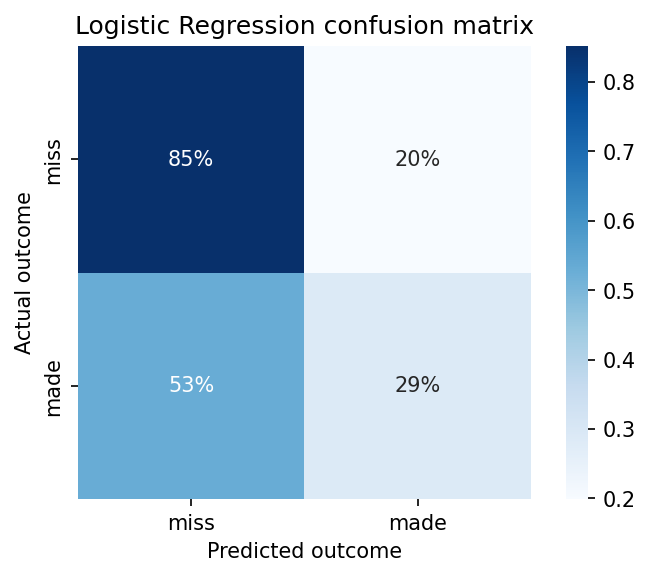

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


print(confusion_matrix(ylog_val, ylog_pred))
cfm = confusion_matrix(ylog_val, ylog_pred)

plt.figure(dpi=150)
sns.heatmap(cfm/cfm.sum(axis=1), cmap=plt.cm.Blues, annot=True, fmt='.0%', square=True,
           xticklabels=['miss', 'made'], yticklabels=['miss', 'made'])

plt.xlabel('Predicted outcome')
plt.ylabel('Actual outcome')
plt.title('Logistic Regression confusion matrix')
plt.show()

This is almost exactly the same matrix as the K nearest neighbors model produced using only the coordinates of the shot on the court.

### Random Forest

A tree-based model will allow us to consider interactions without specifying them. Interactions in this case should be important (e.g. distance and zone) so a random forest model is expected to increase precision. 

In [31]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# train model on training data
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [33]:
# make predictions on validation set
y_pred = rf.predict(X_val)

# get model performance score
print(f'Precision: {precision_score(y_val, y_pred)}')
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"F1: {f1_score(y_val, y_pred)}")

Precision: 0.4909983633387889
Recall: 0.45248868778280543
F1: 0.4709576138147567


Model performance is worse than the logistic regression baseline

In [34]:
feature_list = list(X.columns)

In [37]:
from sklearn.tree import export_graphviz
import pydot

tree = rf.estimators_[5]
export_graphviz(tree, out_file='tree.dot', feature_names=feature_list, rounded=True, precision=1)

(graph, ) = pydot.graph_from_dot_file('tree.dot')

graph.write_png('tree.png')

In [56]:
# Try a smaller tree
rf_small = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

# train model on training data
rf_small.fit(X_train, y_train)

# predict
y_pred_small = rf_small.predict(X_val)

# performance
print(f'Precision: {precision_score(y_val, y_pred_small)}')
print(f"Recall: {recall_score(y_val, y_pred_small)}")
print(f"F1: {f1_score(y_val, y_pred_small)}")

Precision: 0.5900621118012422
Recall: 0.2865761689291101
F1: 0.38578680203045684


Limiting the tree depth to 3 increases precision back to the baseline level

In [39]:
# Visualize the tree
tree_small = rf_small.estimators_[5]
export_graphviz(tree_small, out_file='tree_small.dot', feature_names=feature_list, rounded=True, precision=1)

(graph, ) = pydot.graph_from_dot_file('tree_small.dot')

graph.write_png('tree_small.png')

In [50]:
rf_small.score(X_val, y_val)

0.6104314230521571

In [53]:
print(X_val.shape, y_val.shape)

(1553, 13) (1553,)


In [54]:
print(X_train.shape, y_train.shape)

(4658, 13) (4658,)


In [58]:
# what if we drop the season variable?
Xt_train = X_train.drop(columns='SEASON')
Xt_val = X_val.drop(columns='SEASON')

In [65]:
# Try a smaller tree
rf_small_t = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

# train model on training data
rf_small_t.fit(Xt_train, y_train)

# predict
y_pred_small_t = rf_small_t.predict(Xt_val)

# performance
print(f'Precision: {precision_score(y_val, y_pred_small_t)}')
print(f"Recall: {recall_score(y_val, y_pred_small_t)}")
print(f"F1: {f1_score(y_val, y_pred_small_t)}")

Precision: 0.590625
Recall: 0.2850678733031674
F1: 0.38453713123092575


In [69]:

# Visualize the tree
tree_small_t = rf_small_t.estimators_[5]
export_graphviz(tree_small_t, out_file='tree_small_t.dot', feature_names=feature_list_t, rounded=True, precision=1)

(graph, ) = pydot.graph_from_dot_file('tree_small_t.dot')

graph.write_png('tree_small_t.png')

In [72]:
Xt_test = X_test.drop(columns='SEASON')

In [73]:
# Try a smaller tree
rf_small_t = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

# train model on training data
rf_small_t.fit(Xt_train, y_train)

# predict
y_pred_test = rf_small_t.predict(Xt_test)

# performance
print(f'Precision: {precision_score(y_test, y_pred_test)}')
print(f"Recall: {recall_score(y_test, y_pred_test)}")
print(f"F1: {f1_score(y_test, y_pred_test)}")

Precision: 0.60790273556231
Recall: 0.30721966205837176
F1: 0.40816326530612246


In [71]:
shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7764 entries, 0 to 7763
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   SEASON                      7764 non-null   int64
 1   PERIOD                      7764 non-null   int64
 2   SHOT_MADE_FLAG              7764 non-null   int64
 3   AREA_Back Court(BC)         7764 non-null   uint8
 4   AREA_Center(C)              7764 non-null   uint8
 5   AREA_Left Side Center(LC)   7764 non-null   uint8
 6   AREA_Left Side(L)           7764 non-null   uint8
 7   AREA_Right Side Center(RC)  7764 non-null   uint8
 8   AREA_Right Side(R)          7764 non-null   uint8
 9   RANGE_16-24 ft.             7764 non-null   uint8
 10  RANGE_24+ ft.               7764 non-null   uint8
 11  RANGE_8-16 ft.              7764 non-null   uint8
 12  RANGE_Back Court Shot       7764 non-null   uint8
 13  RANGE_Less Than 8 ft.       7764 non-null   uint8
dtypes: int64